#Text Summarization
---


Text summarization is a technique to abridge lengthy and voluminous pieces of information. The motive is to shorten the text while keeping the semantics and the key message intact.

This notebook implements 3 layer stacked lstm encoder decoder network for text summarization. For more details refer to "ts_attention_lstm_v2.ipynb".

Note: This notebook contains brief explanations if any. Please refer to "ts_attention_lstm_v2.ipynb" for a deeper understanding.

In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import os
import pickle
from google.colab import drive

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Dataset Description:

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

<br>Data includes:

* Reviews from Oct 1999 - Oct 2012
* 568,454 reviews
* 256,059 users
* 74,258 products

It consists of following columns: \['**Id**', '**ProductId**', '**UserId**', '**ProfileName**', '**HelpfulnessNumerator**', '**HelpfulnessDenominator**', '**Score**', '**Time**', '**Summary**', '**Text**']. However, we are only concerned with the Text and Summary. 

Data is available as a part of a [Kaggle competition](https://www.kaggle.com/snap/amazon-fine-food-reviews) and is stored in google drive for ease in access.

In [ ]:
#Download the dataset and read it
!gdown --id 1FyIy2yUM9CAA8wBH_wxyZpHR4fxVuTdQ
!gdown --id 1sPBc_5oE7GA-zA_MDYzRSDyijDPvUr0j

Downloading...
From: https://drive.google.com/uc?id=1FyIy2yUM9CAA8wBH_wxyZpHR4fxVuTdQ
To: /content/Reviews.csv
301MB [00:03, 86.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sPBc_5oE7GA-zA_MDYzRSDyijDPvUr0j
To: /content/contraction_dict.pickle
100% 3.55k/3.55k [00:00<00:00, 1.58MB/s]


In [ ]:
#Read the csv
#
# Considering the training time and colab hardware restrictions, 
# it is advisable to train the model on a fraction of the data.
# 100000 rows would suffice here.
df = pd.read_csv('Reviews.csv', usecols=['Summary', 'Text'], nrows=100000)

#Dropping duplicate text
df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True)

#Check out the data
df.head(5)

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
#Download stopwords
stop_words = set(stopwords.words('english'))

#Load the contraction_dict
#It maps 'I've' -> 'I have'
with open('contraction_dict.pickle', 'rb') as handle:
    contraction_mapping = pickle.load(handle)

# Preprocess Text
def text_cleaner(review):
    
    review = review.lower()
    review = BeautifulSoup(review, "lxml").text
    review = re.sub(r'\([^)]*\)', '', review)
    review = re.sub('"','', review)
    review = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in review.split(" ")])    
    review = re.sub(r"'s\b","",review)
    review = re.sub("[^a-zA-Z]", " ", review) 
    review = [w for w in review.split() if w not in stop_words]
    
    return " ".join([i for i in review if len(i)>2])

#Preprocess Summary
def summary_cleaner(summary):
    
    summary = re.sub('"','', summary)
    summary = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in summary.split(" ")])    
    summary = re.sub(r"'s\b","",summary)
    summary = re.sub("[^a-zA-Z]", " ", summary)
    summary = summary.lower()
    summary= summary.split()
    
    return " ".join([i for i in summary if len(i)>1])

In [ ]:
#Apply the functions to our dataset
df.Text = df.Text.apply(text_cleaner)
df.Summary = df.Summary.apply(summary_cleaner)

#Dropping empty strings
df['Summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

#Check out the preprocessed data
print(df.head(5))
print("No of rows post processing: ", df.shape[0])

                 Summary                                               Text
0  good quality dog food  bought several vitality canned dog food produc...
1      not as advertised  product arrived labeled jumbo salted peanuts p...
2    delight says it all  confection around centuries light pillowy citr...
3         cough medicine  looking secret ingredient robitussin believe f...
4            great taffy  great taffy great price wide assortment yummy ...
No of rows post processing:  88356


Fraction of texts with less than 80 words is 0.9070464937299109
Fraction of summaries with less than 10 words is 0.9646430349947938


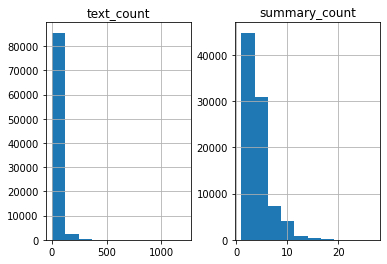

In [ ]:
#Analyse the len of texts and summaries
#Finalize maximum text and summary length
text_word_count = np.array([len(w.split()) for w in df.Text], dtype='int')
summary_word_count = np.array([len(w.split()) for w in df.Summary], dtype='int')

pd.DataFrame({"text_count":text_word_count, "summary_count":summary_word_count}).hist()

#Set the maximum lengths
MAX_TEXT_LEN = 80
MAX_SUM_LEN = 10

print("Fraction of texts with less than {} words is {}".format(MAX_TEXT_LEN, np.mean(text_word_count<MAX_TEXT_LEN) ))
print("Fraction of summaries with less than {} words is {}".format(MAX_SUM_LEN, np.mean(summary_word_count<MAX_SUM_LEN)))

In [ ]:
#Truncate text to MAX_TEXT_LEN 
#Truncate summary to (MAX_SUM_LEN - 2), prepend start token 'xstartx' and append end token 'xendx'
df_pro = pd.DataFrame()

df_pro['Text'] = df['Text'].map(lambda text: ' '.join(text.split()[-(MAX_TEXT_LEN-2):]))
df_pro['Summary'] = df['Summary'].map(lambda text: ' '.join(['xstartx'] + text.split()[-(MAX_SUM_LEN-2):] + ['xendx']))

#Check out the result
for _, row in df_pro.sample(5).iterrows():
    print("Review_{}: {}".format(len(row['Text'].split()), row['Text']))
    print("Summary_{}: {}".format(len(row['Summary'].split()), row['Summary']))
    print("")

Review_54: start big fan blue diamond brand almonds really like bold flavors habanero bbq lime chili never seen blazin buffalo wing flavor local grocery store ordered amazon first put almond mouth get initial hint buffalo wing flavor quickly goes away tastes kind strange bad favorite every bodies taste buds different might like think buy flavor
Summary_6: xstartx taste kind of strange xendx

Review_78: blech food smelly like ounce cans tried save money getting bigger cans giving half covering storing half later refrigerator like food cold seems get wasted like smaller cans ultimately long food thing matters kitty eat happy get update december finished last last night kitty enjoyed every single one chicken pot pie little bothersome much liquid careful opened would wear juice yes nice juice still want kitty really liked juice worth extra effort careful opened order cycle canned food
Summary_10: xstartx cuisine variety pack chinese chicken chicken pot pie xendx

Review_29: good price tast

In [ ]:
#Splitting the train and validation set
txt_train, txt_val, sum_train, sum_val = train_test_split(df_pro['Text'], df_pro['Summary'], test_size=0.1, random_state=0, shuffle=True)

#Check out the shapes of the resulting partition
print('Rows -> txt_train: {}, txt_val: {}, sum_train: {}, sum_val: {}'.
      format(txt_train.shape[0], txt_val.shape[0], sum_train.shape[0], sum_val.shape[0]))

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(txt_train.tolist())

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(txt_train) 
x_val   =   x_tokenizer.texts_to_sequences(txt_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=MAX_TEXT_LEN, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=MAX_TEXT_LEN, padding='post')

#Set vocab size to #Unique_words + 1(for 0 which is padding)
x_voc_size   =  len(x_tokenizer.word_index) +1

#Sanity Check
print('\nx_tr.shape: ', x_tr.shape)
print('x_val.shape: ', x_val.shape)

####
# Doing the same process for summaries
####

#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(sum_train.tolist())

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(sum_train) 
y_val   =   y_tokenizer.texts_to_sequences(sum_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=MAX_SUM_LEN, padding='post')
y_val   =   pad_sequences(y_val, maxlen=MAX_SUM_LEN, padding='post')

#Set vocab size to #Unique_words + 1(for 0 which is padding)
y_voc_size  =   len(y_tokenizer.word_index) +1

#Sanity Check
print('\ny_tr.shape: ', y_tr.shape)
print('y_val.shape: ', y_val.shape)
print('\nx_voc_size: ', x_voc_size, '\ny_voc_size: ', y_voc_size)

#Sanity Check
for i in np.random.randint(5000, size=(5,)): 
  print('\nTrue summary: ', y_tokenizer.sequences_to_texts([y_tr[i]]))
  print('Processed summary: ', y_tr[i])

Rows -> txt_train: 79520, txt_val: 8836, sum_train: 79520, sum_val: 8836

x_tr.shape:  (79520, 80)
x_val.shape:  (8836, 80)

y_tr.shape:  (79520, 10)
y_val.shape:  (8836, 10)

x_voc_size:  48222 
y_voc_size:  13871

True summary:  ['xstartx hearty and bold xendx']
Processed summary:  [   1 1284    8  237    2    0    0    0    0    0]

True summary:  ['xstartx no cal sweetener you should try this one xendx']
Processed summary:  [  1  49 827 673  34 395 228  14  72   2]

True summary:  ['xstartx expensive but worth it xendx']
Processed summary:  [  1 135  12 145  10   2   0   0   0   0]

True summary:  ['xstartx chocolate was melted xendx']
Processed summary:  [  1  51  99 790   2   0   0   0   0   0]

True summary:  ['xstartx great so far xendx']
Processed summary:  [  1   3  40 207   2   0   0   0   0   0]


##Model Building

The encoder model consists of following parts-

1. Embedding layer
  * Input: (None, 80)
  * Output: (None, 80, 256)

2. 3 LSTM layers stacked on top of each other.
  * Input: (None, 80, 256)
  * Output: "Hidden_state" - (None, 80, 256), "state_h" - (None, 256), "state_c" - (None, 256) 

The decoder model is made up of-

1. Embedding Layer
  * Input: (None,) **Note: Here we avoid specifying sequence length of summary, since in inference phase we would like to predict 1 word at a time.**
  * Output: (None, None, 256)

2. LSTM layer
  * Input: (None, None, 256)
  * Output: "Hidden_state" - (None, None, 256), "state_h" - (None, 256), "state_c" - (None, 256)

3. TimeDistributed Layer with softmax activation
  * Input: (None, None, 256)
  * Output: (None, None, 13871)

Notice that this model is a simple modeline against which performance of other two models will be compared.

In [ ]:
latent_dim = 256

# Encoder 
encoder_inputs = tf.keras.layers.Input(shape=(MAX_TEXT_LEN,)) 
enc_emb = tf.keras.layers.Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = tf.keras.layers.LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = tf.keras.layers.LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = tf.keras.layers.Input(shape=(None,)) 
dec_emb_layer = tf.keras.layers.Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Dense layer
decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_outputs) 

# Define the model
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 256)      12344832    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 256), (N 525312      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

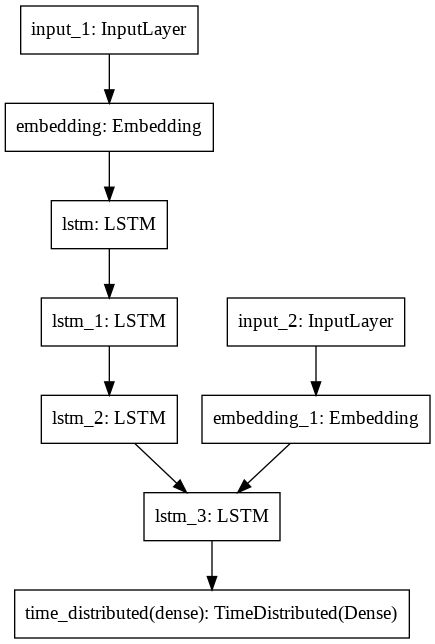

In [ ]:
#Plot the model
tf.keras.utils.plot_model(model) #Complete model
#tf.keras.models.Model(encoder_inputs, encoder_outputs) #Encoder Model

### Callbacks

* CSVLogger - To keep track of train and val loss.
* EarlyStopping - To terminate training in case of overfitting.
* ModelCheckpoint - Save model to avoid retraining if colab crashes

In [ ]:
#Callbacks
#This requires a drive mount
drive_root = '/content/drive/My Drive'
model_name = 'stacked_lstm'

#Check if drive is mounted
if not os.path.exists(drive_root):
  print("Please mount google drive for this operation")
  drive.mount('/drive')

#CSVLogger paths
#Check if they exist
csv_dir = os.path.join(drive_root, 'csvLogger')
csv_filename = os.path.join(csv_dir, f'{model_name}.csv')

if not os.path.exists(csv_dir):
  os.makedirs(csv_dir)
  print("CSV directory created at path: ", csv_dir)
else:
  print("CSV directory already exist at path: ", csv_dir)

#ModelCheckpoint paths
#Check if they exist
checkpoint_dir = os.path.join(drive_root, 'checkpoints/project', model_name) #stacked_lstm checkpoints are stored here. Separate for different folders
checkpoint_path = os.path.join(checkpoint_dir, model_name + '_e{epoch}_vl_{val_loss:0.4f}.ckpt')

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
  print("Checkpoints directory created at path: ", checkpoint_dir)
else:
  print("Checkpoints folder already exists at path: ", checkpoint_dir)  

#Create a callback that logs the content in CSV
csv_logger = tf.keras.callbacks.CSVLogger(csv_filename,
                                          separator=',',
                                          append=True)

# Create a callback that stops training for no improvement
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=5)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=False,
                                                 verbose=1)

CSV directory already exist at path:  /content/drive/My Drive/csvLogger
Checkpoints folder already exists at path:  /content/drive/My Drive/checkpoints/project/stacked_lstm


###Model Training

1. Load the latest checkpoint if any.
2. Resume or start training.

In [ ]:
#Load the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)

if latest != None:
  print("Loading weights from: ", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from:  /content/drive/My Drive/checkpoints/project/stacked_lstm/stacked_lstm_e20_vl_2.2878.ckpt


In [ ]:
#Model training
#Uncomment this to train it on toy dataset, overfit and check if everything works fine.

# history = model.fit([x_tr[:32],y_tr[:32,:-1]], y_tr[:32][:,1:,np.newaxis],
#                     epochs=10, batch_size=16,
#                     validation_data = ([x_val[:32],y_val[:32,:-1]], y_val[:32][:,1:,np.newaxis]))

In [ ]:
#Train Model on Complete Dataset
history = model.fit([x_tr[:],y_tr[:,:-1]], y_tr[:][:,1:,np.newaxis],
                    epochs=50, batch_size=512, initial_epoch = 18,
                    validation_data = ([x_val[:],y_val[:,:-1]], y_val[:][:,1:,np.newaxis]),
                    callbacks=[cp_callback, es, csv_logger])

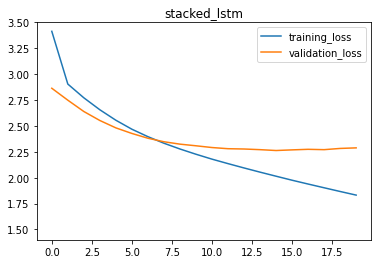

In [ ]:
#Let's check out the model performance
perf_df = pd.read_csv(csv_filename)

plt.ylim(1.4, 3.5)
plt.plot(perf_df['loss'], label='training_loss')
plt.plot(perf_df['val_loss'], label='validation_loss')
plt.legend()
plt.title(f'{model_name}')
plt.show()

##Model Inference

The model for inference is slightly different from the trained model. Here instead of feeding the decoder with input for every timestep, we start by feeding 'xstartx' token. The prediction of the decoder at timestep t act as input for timestep t+1.

In [ ]:
# encoder inference
encoder_model = tf.keras.models.Model(inputs=encoder_inputs,outputs=[state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim,))
decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim,))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs3 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = tf.keras.models.Model(
[decoder_inputs] + [decoder_state_input_h, decoder_state_input_c],
[decoder_outputs3] + [state_h2, state_c2])

In [ ]:
#Some useful dictionaries
reverse_target_word_index = y_tokenizer.index_word.copy() 
reverse_source_word_index = x_tokenizer.index_word.copy()
target_word_index = y_tokenizer.word_index.copy()

In [ ]:
#Let the padding token '0' represent empty string
reverse_target_word_index[0] = ''

#It's handy to vecotrize mapping from index word operation in numpy.
rtwi = np.vectorize(reverse_target_word_index.get)

#Decode output
def predict_sequences(input_seq):

  # Encode the input as state vectors.
  e_h, e_c = encoder_model.predict(input_seq)
  # input_seq.shape[0] -> BS
  # "e_out" - (BS, 80, 256), "e_h" - (BS, 256), "e_c" - (BS, 256)
  
  # Generate empty target sequence of length 1.
  target_seq = np.zeros(input_seq.shape[0])

  # Chose the 'start' word as the first words of the target sequences
  target_seq.fill(target_word_index['xstartx'])

  #This will store the string representation of decoded sequence
  decoded_sentence = np.chararray(shape=(input_seq.shape[0],1), unicode=True)

  for i in range(MAX_SUM_LEN):

      output_tokens, h, c = decoder_model.predict([target_seq.reshape(-1,1)] + [e_h, e_c])
      # "output_tokens" - (BS, 1, 13871), "h" - (BS, 256), "c" - (BS, 256)
      
      # Pick the max probability token for each sequence
      sampled_token_index = np.argmax(output_tokens, axis=-1)
      #shape - (BS,1)

      #Map the index to corresponding word and
      #concatenate it with the decoded_sequence
      decoded_sentence = decoded_sentence + np.char.add(rtwi(sampled_token_index),' ') 

      # Update the target sequence to newly predicted outputs.
      target_seq = sampled_token_index.ravel()

      # Update internal states
      e_h, e_c = h, c

  #Return after remove and stripping whitespace  
  return decoded_sentence.replace('xendx', '').strip()

In [ ]:
##Create a dictionary for inference on validation data
infer_dict = {'val_text': [], 'val_true': [], 'val_pred': [], 'bleu_score': []}

val_true = np.char.array(y_tokenizer.sequences_to_texts(y_val), unicode=True).replace('xstartx','').replace('xendx', '').strip()
infer_dict['val_true'] = val_true.tolist()
infer_dict['val_text'] = x_tokenizer.sequences_to_texts(x_val)
infer_dict['val_pred'] = predict_sequences(x_val).ravel().tolist()

In [ ]:
#Calculate bleu score
infer_dict['bleu_score'] = [sentence_bleu([r.split()], h.split(), weights=[1,0,0,0]) 
                            for r,h in zip(infer_dict['val_true'], infer_dict['val_pred'])]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
#Make a dataframe from inference dictionary and export it
infer_df = pd.DataFrame(infer_dict)
infer_df.to_csv(os.path.join(csv_dir, f'{model_name}_infer.csv'))

infer_df.head()

,val_text,val_true,val_pred,bleu_score
0,recently student class brought liquorice share...,mmmmm good,best tasting hot sauce ever,0.000000
1,coffee drinkers tastes wide varied like coffee...,not great not terrible,not as good as it as good as it,0.111111
2,one best tasting granola good ceral well regul...,great tasting but bit pricey,great taste,0.111565
3,say wow tangy sweet fruity refreshing hard ima...,the gum chewing has been waiting for,best tasting hot sauce ever,0.000000
4,used eating flaxseed brownie hodgson mill brow...,delicious brownie,delicious,0.367879


In [ ]:
#Print some random results
print("Let's print some random results from inference dataframe -")
for i, row in infer_df.sample(5).iterrows():
  
  print("\nText: ", row['val_text'])
  print("Original Summary: ", row['val_true'])
  print("Predicted Summary: ", row['val_pred'])
  print("BLEU unigram score: ", row['bleu_score'])

print("\nAverage BLEU score: ", infer_df.bleu_score.mean())

Let's print some random results from inference dataframe -

Text:  bought pack senseo paris french vanilla caramel bistro pods pretty weak could make cup coffee actually stopped filling weak probably buy
Original Summary:  senseo pod review
Predicted Summary:  not good
BLEU unigram score:  0.0

Text:  purchased tea seeing great reviews disappointed arrived immediately opened delighted fragrance tea took several deep breaths actually making tea smells good comforting one new favorites like fragrant teas like want tea like reuse tea bags although second cup quite nice nice plain feel like comfy aroma begs complimented little milk honey definitely ordering tea harney sons get adorable tins tea comes
Original Summary:  delicously fragrant
Predicted Summary:  tea time
BLEU unigram score:  0.0

Text:  read reviews grain salt couple people thought awful purchase three flavors eat whatever mood enjoy bottom line try box purchased locally like buy case amazon cheaper price complaint amazon groc